# 导入所需要的库

In [28]:
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
# matplotlib支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']

# 读取数据集

In [2]:
insects_training = pd.read_csv('./insects/insects-training.txt',header=None,sep=' ')
insects_testing = pd.read_csv('./insects/insects-testing.txt',header=None,sep=' ')
insects_2_training = pd.read_csv('./insects/insects-2-training.txt',header=None,sep=' ')
insects_2_testing = pd.read_csv('./insects/insects-2-testing.txt',header=None,sep=' ')

In [3]:
insects_training0=insects_training.to_numpy()[insects_training.to_numpy()[:,2]==0]
insects_training1=insects_training.to_numpy()[insects_training.to_numpy()[:,2]==1]
insects_training2=insects_training.to_numpy()[insects_training.to_numpy()[:,2]==2]

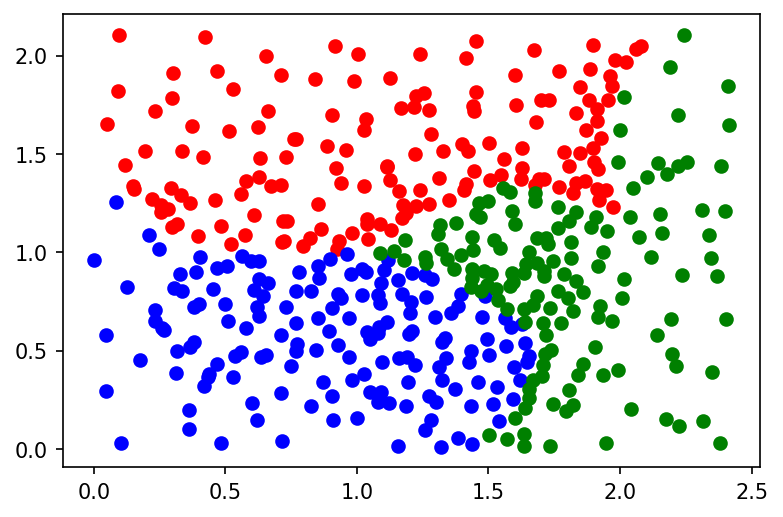

In [4]:
plt.figure(dpi=150)
plt.plot(insects_training0[:,0],insects_training0[:,1],'ro')
plt.plot(insects_training1[:,0],insects_training1[:,1],'bo')
plt.plot(insects_training2[:,0],insects_training2[:,1],'go')
plt.show()

In [110]:
# 定义前馈神经网络模型
class FeedForwardNet(nn.Module):
    '''
    input_size: 输入层的维度
    hidden_size: 隐藏层的维度
    output_size: 输出层的维度
    num_layers: 隐藏层的层数
    activation: 激活函数
    '''
    def __init__(self, input_size, hidden_size, output_size, num_layers, activation):
        torch.manual_seed(0) # 设置随机种子
        super().__init__() # 调用父类的构造函数
        
        self.num_layers = num_layers
        
        # 定义输入层
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # 定义隐藏层
        self.hidden_layers = nn.ModuleList()
        for i in range(num_layers-1):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        
        # 定义输出层
        self.output_layer = nn.Linear(hidden_size, output_size)
        
        # 定义激活函数
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.Tanh()
        
        # 定义softmax函数
        # self.sm=nn.Softmax(dim=1)

    # 前向传播
    def forward(self, x):
        out = self.input_layer(x)
        out = self.activation(out)
        
        for i in range(self.num_layers-1):
            out = self.hidden_layers[i](out)
            out = self.activation(out)
            
        out = self.output_layer(out)
        
        return out
    
# 定义训练函数和测试函数
def fit(model, optimizer, criterion, x, y, epochs, tol=1e-2):
    losses = []
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # if (epoch + 1) % 200 == 0:
        #     print('epoch: {}, train_loss: {:.6f}'.format(epoch+1, loss.item()))
        if epoch >= 2:
            if losses[-1] < tol:
                print('epoch: {}, train_loss: {:.6f}'.format(epoch+1, loss.item()))
                return losses
    print('epoch: {}, train_loss: {:.6f}'.format(epochs, loss.item()))
    return losses

def predict(model, x):
    with torch.no_grad():
        y_pred = model(x)
    return y_pred

# 无噪声数据集

In [93]:
data=insects_training.to_numpy()
x=data[:,:2]
y=data[:,2]
x=torch.from_numpy(x).float()
y=torch.from_numpy(y).long()

 48%|████▊     | 2394/5000 [00:06<00:06, 380.22it/s]


epoch: 2395, train_loss: 0.000999


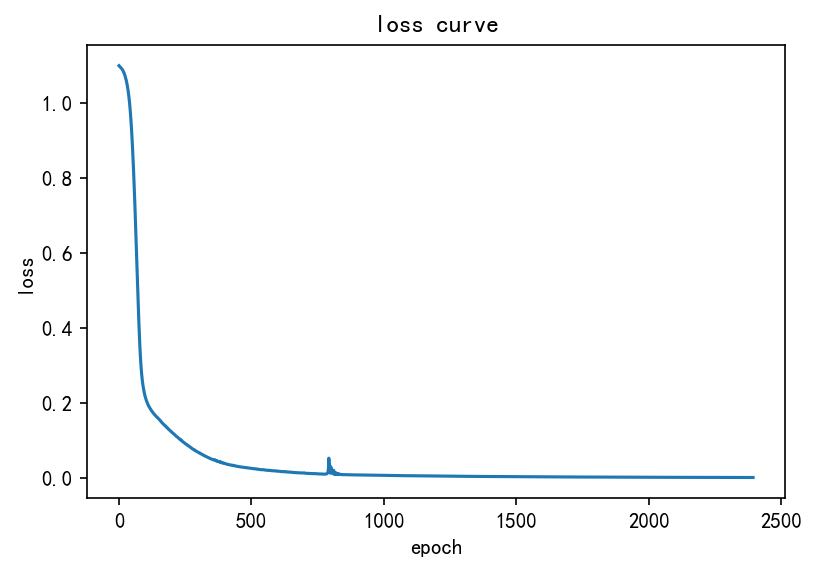

In [111]:
model = FeedForwardNet(input_size=2, hidden_size=32, output_size=3, num_layers=5, activation='relu')
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
losses= fit(model, optimizer, criterion, x, y, epochs=5000, tol=1e-3)

# 绘制损失函数的变化曲线
plt.figure(dpi=150)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss curve')
plt.plot(losses)
plt.show()

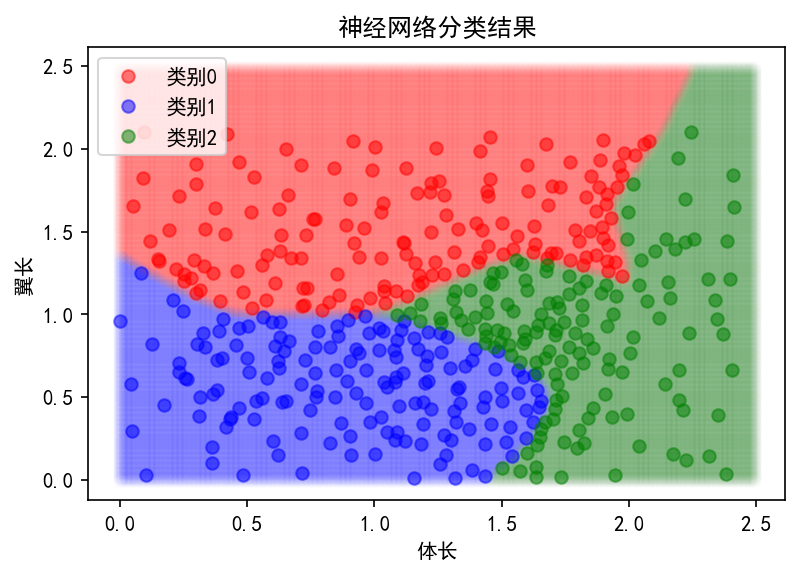

In [113]:
x1 = np.arange(0, 2.5, 0.01)
x2 = np.arange(0, 2.5, 0.01)
x1, x2 = np.meshgrid(x1, x2)
x_test = np.c_[x1.ravel(), x2.ravel()]
x_test = torch.from_numpy(x_test).float()
y_pred = predict(model, x_test)
y_pred = y_pred.numpy()
y_pred = np.argmax(y_pred, axis=1)
plt.figure(dpi=150)
plt.plot(x_test[y_pred==0,0],x_test[y_pred==0,1],'ro',alpha=0.01)
plt.plot(x_test[y_pred==1,0],x_test[y_pred==1,1],'bo',alpha=0.01)
plt.plot(x_test[y_pred==2,0],x_test[y_pred==2,1],'go',alpha=0.01)
plt.plot(data[data[:,2]==0,0],data[data[:,2]==0,1],'ro',alpha=0.5,label='类别0')
plt.plot(data[data[:,2]==1,0],data[data[:,2]==1,1],'bo',alpha=0.5,label='类别1')
plt.plot(data[data[:,2]==2,0],data[data[:,2]==2,1],'go',alpha=0.5,label='类别2')
plt.xlabel('体长')
plt.ylabel('翼长')
plt.title('神经网络分类结果')
plt.legend()
plt.show()

In [112]:
# 测试模型
x_test = insects_testing.to_numpy()[:,:2]
y_test = insects_testing.to_numpy()[:,2]
x_test = torch.from_numpy(x_test).float()
y_pred = predict(model, x_test)
y_pred = y_pred.numpy()
y_pred = np.argmax(y_pred, axis=1)
print('test accuracy: {:.6f}'.format(np.sum(y_pred==y_test)/len(y_test)))


test accuracy: 1.000000


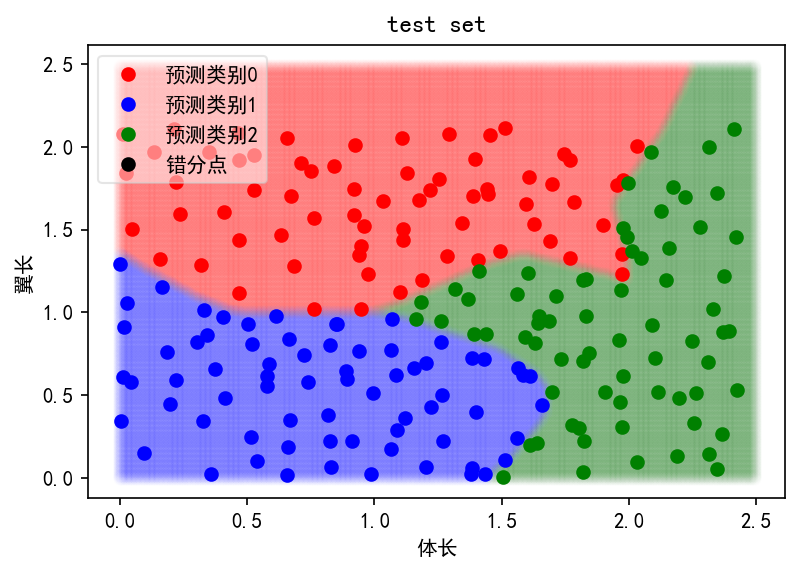

In [117]:
# 绘制测试集，并将异常点标记为黑色
x1 = np.arange(0, 2.5, 0.01)
x2 = np.arange(0, 2.5, 0.01)
x1, x2 = np.meshgrid(x1, x2)
x_test1 = np.c_[x1.ravel(), x2.ravel()]
x_test1 = torch.from_numpy(x_test1).float()
y_pred1 = predict(model, x_test1)
y_pred1 = y_pred1.numpy()
y_pred1 = np.argmax(y_pred1, axis=1)
x_test = insects_testing.to_numpy()[:,:2]
y_test = insects_testing.to_numpy()[:,2]
x_test = torch.from_numpy(x_test).float()
y_pred = predict(model, x_test)
y_pred = y_pred.numpy()
y_pred = np.argmax(y_pred, axis=1)
plt.figure(dpi=150)
plt.plot(x_test1[y_pred1==0,0],x_test1[y_pred1==0,1],'ro',alpha=0.01)
plt.plot(x_test1[y_pred1==1,0],x_test1[y_pred1==1,1],'bo',alpha=0.01)
plt.plot(x_test1[y_pred1==2,0],x_test1[y_pred1==2,1],'go',alpha=0.01)
plt.plot(x_test[y_pred==0,0],x_test[y_pred==0,1],'ro',label='预测类别0')
plt.plot(x_test[y_pred==1,0],x_test[y_pred==1,1],'bo',label='预测类别1')
plt.plot(x_test[y_pred==2,0],x_test[y_pred==2,1],'go',label='预测类别2')
plt.plot(x_test[y_test!=y_pred,0],x_test[y_test!=y_pred,1],'ko',label='错分点')
plt.xlabel('体长')
plt.ylabel('翼长')
plt.title('test set')
# 图例透明度
plt.legend(framealpha=0.5,loc='upper left')
plt.show()

# 有噪声数据集

## 被pass的噪声处理，效果并不是很好

In [9]:
# from scipy.spatial import distance
# data1=insects_2_training.to_numpy()
# dist_matrix=distance.cdist(data1[:,:2],data1[:,:2],'euclidean')
# dist_matrix[dist_matrix==0]=np.inf
# # 如果一个点和与它最近的3个点内颜色最多的点颜色不同，则将其标记为异常点
# for i in range(len(data1)):
#     index=np.argsort(dist_matrix[i])[:10]
#     if np.argmax(np.bincount(data1[index,2].astype(int)))!=data1[i,2]:
#         data1[i,2]=3
# data1=data1[data1[:,2]!=3]

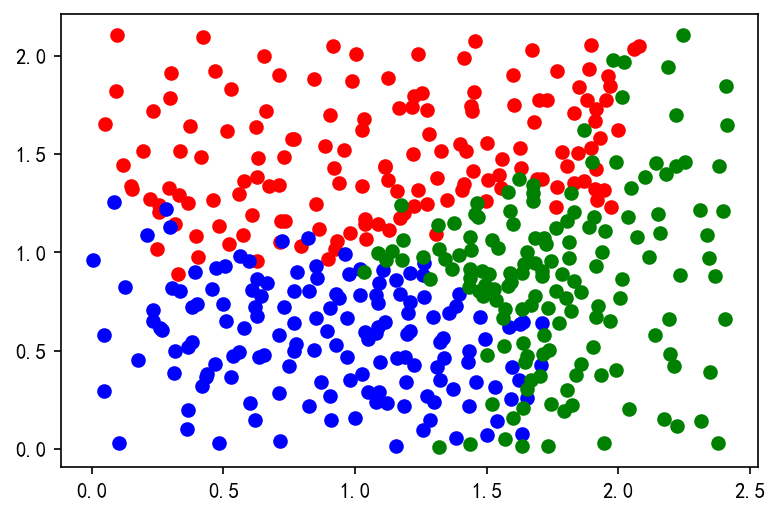

In [135]:
data1=insects_2_training.to_numpy()
# 对数据进行打乱
# np.random.shuffle(data1)

# 绘制训练集
plt.figure(dpi=150)
plt.plot(data1[data1[:,2]==0,0],data1[data1[:,2]==0,1],'ro')
plt.plot(data1[data1[:,2]==1,0],data1[data1[:,2]==1,1],'bo')
plt.plot(data1[data1[:,2]==2,0],data1[data1[:,2]==2,1],'go')
plt.show()

In [136]:
# data1=insects_2_training.to_numpy()
x=data1[:,:2]
y=data1[:,2]
x=torch.from_numpy(x).float()
y=torch.from_numpy(y).long()

 99%|█████████▉| 4940/5000 [00:11<00:00, 435.58it/s]


epoch: 4941, train_loss: 0.000999


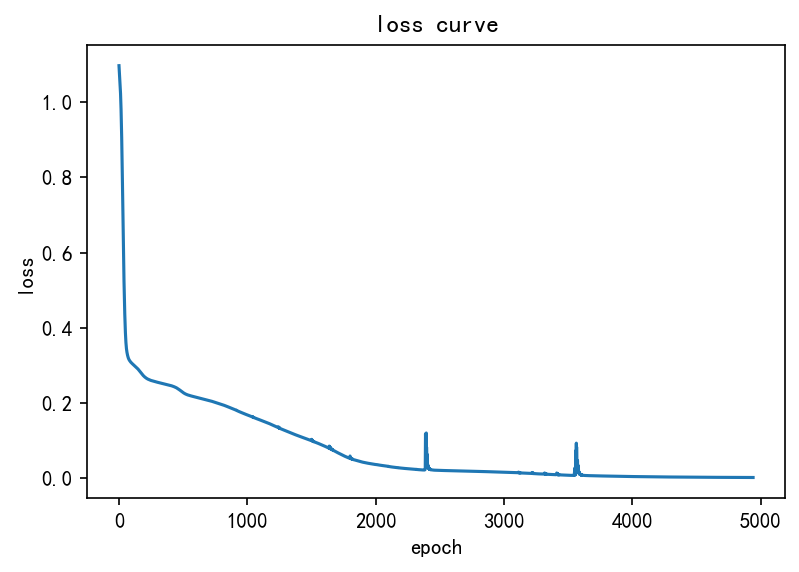

test accuracy: 0.971429


In [149]:
model = FeedForwardNet(input_size=2, hidden_size=32, output_size=3, num_layers=5, activation='tanh')
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
losses= fit(model, optimizer, criterion, x, y, epochs=5000, tol=1e-3)

# 绘制损失函数的变化曲线
plt.figure(dpi=150)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss curve')
plt.plot(losses)
plt.show()
# 测试模型
x_test = insects_2_testing.to_numpy()[:,:2]
y_test = insects_2_testing.to_numpy()[:,2]
x_test = torch.from_numpy(x_test).float()
y_pred = predict(model, x_test)
y_pred = y_pred.numpy()
y_pred = np.argmax(y_pred, axis=1)
print('test accuracy: {:.6f}'.format(np.sum(y_pred==y_test)/len(y_test)))

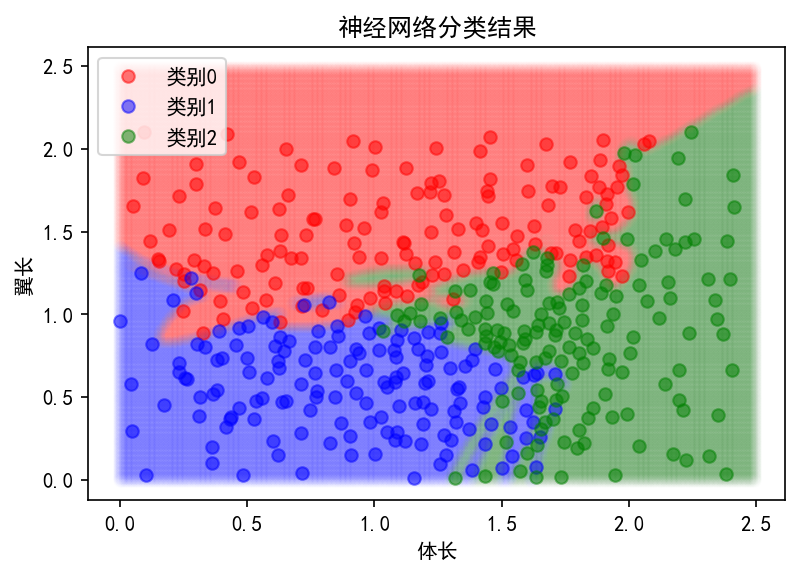

In [138]:
x1 = np.arange(0, 2.5, 0.01)
x2 = np.arange(0, 2.5, 0.01)
x1, x2 = np.meshgrid(x1, x2)
x_test = np.c_[x1.ravel(), x2.ravel()]
x_test = torch.from_numpy(x_test).float()
y_pred = predict(model, x_test)
y_pred = y_pred.numpy()
y_pred = np.argmax(y_pred, axis=1)
plt.figure(dpi=150)
plt.plot(x_test[y_pred==0,0],x_test[y_pred==0,1],'ro',alpha=0.01)
plt.plot(x_test[y_pred==1,0],x_test[y_pred==1,1],'bo',alpha=0.01)
plt.plot(x_test[y_pred==2,0],x_test[y_pred==2,1],'go',alpha=0.01)
plt.plot(data1[data1[:,2]==0,0],data1[data1[:,2]==0,1],'ro',alpha=0.5,label='类别0')
plt.plot(data1[data1[:,2]==1,0],data1[data1[:,2]==1,1],'bo',alpha=0.5,label='类别1')
plt.plot(data1[data1[:,2]==2,0],data1[data1[:,2]==2,1],'go',alpha=0.5,label='类别2')
plt.xlabel('体长')
plt.ylabel('翼长')
plt.title('神经网络分类结果')
plt.legend()
plt.show()

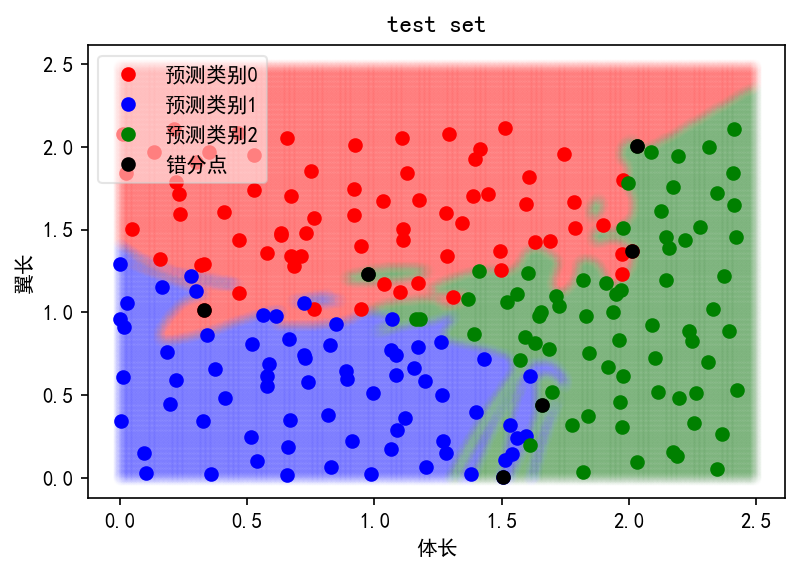

In [139]:
# 绘制测试集，并将异常点标记为黑色
x1 = np.arange(0, 2.5, 0.01)
x2 = np.arange(0, 2.5, 0.01)
x1, x2 = np.meshgrid(x1, x2)
x_test1 = np.c_[x1.ravel(), x2.ravel()]
x_test1 = torch.from_numpy(x_test1).float()
y_pred1 = predict(model, x_test1)
y_pred1 = y_pred1.numpy()
y_pred1 = np.argmax(y_pred1, axis=1)
x_test = insects_2_testing.to_numpy()[:,:2]
y_test = insects_2_testing.to_numpy()[:,2]
x_test = torch.from_numpy(x_test).float()
y_pred = predict(model, x_test)
y_pred = y_pred.numpy()
y_pred = np.argmax(y_pred, axis=1)
plt.figure(dpi=150)
plt.plot(x_test1[y_pred1==0,0],x_test1[y_pred1==0,1],'ro',alpha=0.01)
plt.plot(x_test1[y_pred1==1,0],x_test1[y_pred1==1,1],'bo',alpha=0.01)
plt.plot(x_test1[y_pred1==2,0],x_test1[y_pred1==2,1],'go',alpha=0.01)
plt.plot(x_test[y_pred==0,0],x_test[y_pred==0,1],'ro',label='预测类别0')
plt.plot(x_test[y_pred==1,0],x_test[y_pred==1,1],'bo',label='预测类别1')
plt.plot(x_test[y_pred==2,0],x_test[y_pred==2,1],'go',label='预测类别2')
plt.plot(x_test[y_test!=y_pred,0],x_test[y_test!=y_pred,1],'ko',label='错分点')
plt.xlabel('体长')
plt.ylabel('翼长')
plt.title('test set')
# 图例透明度
plt.legend(framealpha=0.5,loc='upper left')
plt.show()

# 参数调整及分析

In [140]:
data1=insects_2_training.to_numpy()
x=data1[:,:2]
y=data1[:,2]
x=torch.from_numpy(x).float()
y=torch.from_numpy(y).long()
x_test = insects_2_testing.to_numpy()[:,:2]
y_test = insects_2_testing.to_numpy()[:,2]
x_test = torch.from_numpy(x_test).float()

hidden_size: 4


100%|██████████| 5000/5000 [00:07<00:00, 687.88it/s]


epoch: 5000, train_loss: 0.171449
test accuracy: 0.923810
hidden_size: 8


100%|██████████| 5000/5000 [00:07<00:00, 671.44it/s]


epoch: 5000, train_loss: 0.109033
test accuracy: 0.933333
hidden_size: 16


100%|██████████| 5000/5000 [00:08<00:00, 578.97it/s]


epoch: 5000, train_loss: 0.002180
test accuracy: 0.952381
hidden_size: 32


 99%|█████████▉| 4940/5000 [00:10<00:00, 484.09it/s]


epoch: 4941, train_loss: 0.000999
test accuracy: 0.971429
hidden_size: 64


 57%|█████▊    | 2875/5000 [00:07<00:05, 389.54it/s]


epoch: 2876, train_loss: 0.000998
test accuracy: 0.966667
hidden_size: 256


 32%|███▏      | 1607/5000 [00:14<00:30, 110.01it/s]


epoch: 1608, train_loss: 0.000998
test accuracy: 0.966667


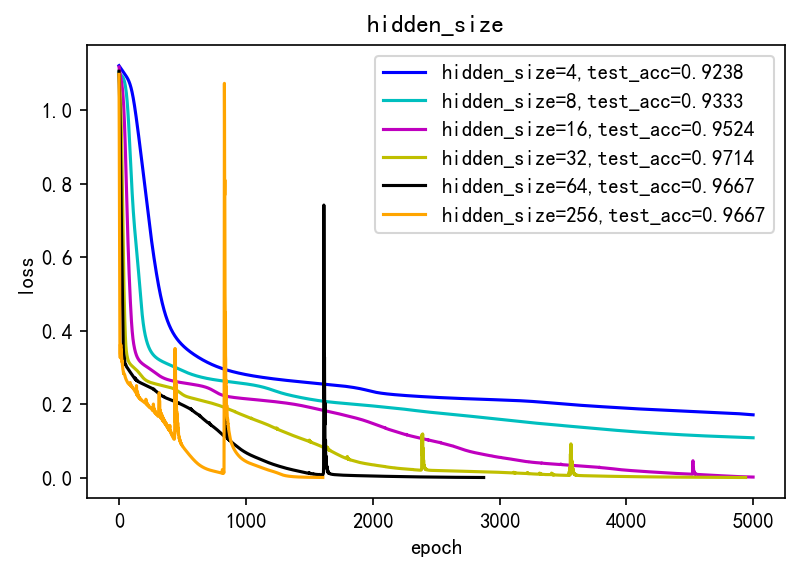

In [153]:
hidden_size = [4,8,16,32,64,256]
num_layers = 5
activation = 'tanh'
learning_rate = 0.001
color=['b', 'c', 'm', 'y', 'k', 'orange', 'r']
plt.figure(dpi=150)

for i,hs in enumerate(hidden_size):
    print('hidden_size: {}'.format(hs))
    model = FeedForwardNet(input_size=2, hidden_size=hs, output_size=3, num_layers=num_layers, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    losses = fit(model, optimizer, criterion, x, y, epochs=5000, tol=1e-3)
    # 计算测试集的准确率
    y_pred = predict(model, x_test)
    y_pred = y_pred.numpy()
    y_pred = np.argmax(y_pred, axis=1)
    acc = np.sum(y_pred==y_test)/len(y_test)
    print('test accuracy: {:.6f}'.format(acc))
    # 绘制损失函数的变化曲线
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('hidden_size')
    plt.plot(losses,color=color[i],label='hidden_size={},test_acc={:.4f}'.format(hs,acc))
plt.legend()
plt.show()


activation function: relu


100%|██████████| 5000/5000 [00:13<00:00, 380.08it/s]


epoch: 5000, train_loss: 0.129680
test accuracy: 0.961905
activation function: sigmoid


100%|██████████| 5000/5000 [00:14<00:00, 345.70it/s]


epoch: 5000, train_loss: 0.061692
test accuracy: 0.961905
activation function: tanh


 99%|█████████▉| 4940/5000 [00:12<00:00, 405.57it/s]


epoch: 4941, train_loss: 0.000999
test accuracy: 0.971429


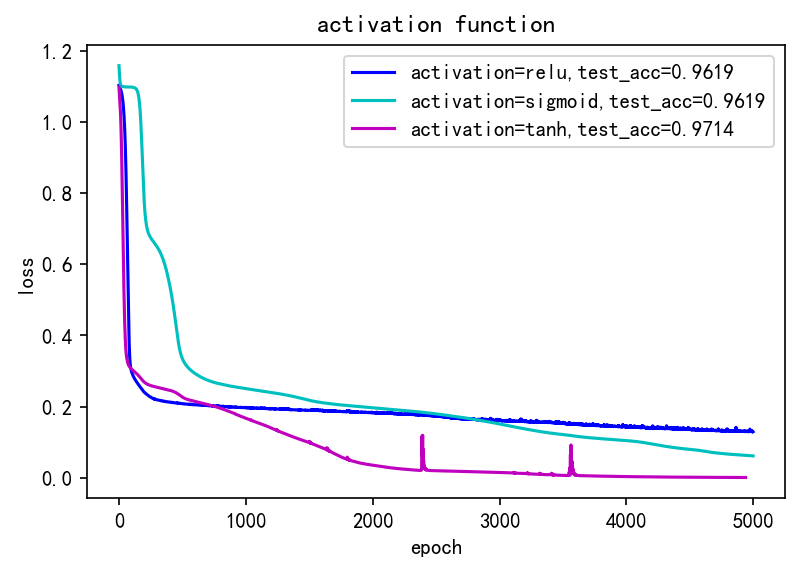

In [144]:
hidden_size = 32
num_layers = 5
activation = ['relu','sigmoid','tanh']
learning_rate = 0.001
color=['b', 'c', 'm']
plt.figure(dpi=150)

for i,ac in enumerate(activation):
    print('activation function: {}'.format(ac))
    model = FeedForwardNet(input_size=2, hidden_size=hidden_size, output_size=3, num_layers=num_layers, activation=ac)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    losses = fit(model, optimizer, criterion, x, y, epochs=5000, tol=1e-3)
    # 计算测试集的准确率
    y_pred = predict(model, x_test)
    y_pred = y_pred.numpy()
    y_pred = np.argmax(y_pred, axis=1)
    acc = np.sum(y_pred==y_test)/len(y_test)
    print('test accuracy: {:.6f}'.format(acc))
    # 绘制损失函数的变化曲线
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('activation function')
    plt.plot(losses,color=color[i],label='activation={},test_acc={:.4f}'.format(ac,acc))
plt.legend()
plt.show()

num_layers:1


100%|██████████| 5000/5000 [00:05<00:00, 917.21it/s] 


epoch: 5000, train_loss: 0.230050
test accuracy: 0.919048
num_layers:3


100%|██████████| 5000/5000 [00:09<00:00, 544.11it/s]


epoch: 5000, train_loss: 0.006824
test accuracy: 0.952381
num_layers:5


 99%|█████████▉| 4940/5000 [00:12<00:00, 385.29it/s]


epoch: 4941, train_loss: 0.000999
test accuracy: 0.971429
num_layers:10


100%|██████████| 5000/5000 [00:21<00:00, 237.48it/s]


epoch: 5000, train_loss: 0.084599
test accuracy: 0.909524
num_layers:15


100%|██████████| 5000/5000 [00:35<00:00, 141.87it/s]


epoch: 5000, train_loss: 0.125982
test accuracy: 0.923810
num_layers:20


100%|██████████| 5000/5000 [00:39<00:00, 125.77it/s]


epoch: 5000, train_loss: 0.171509
test accuracy: 0.923810


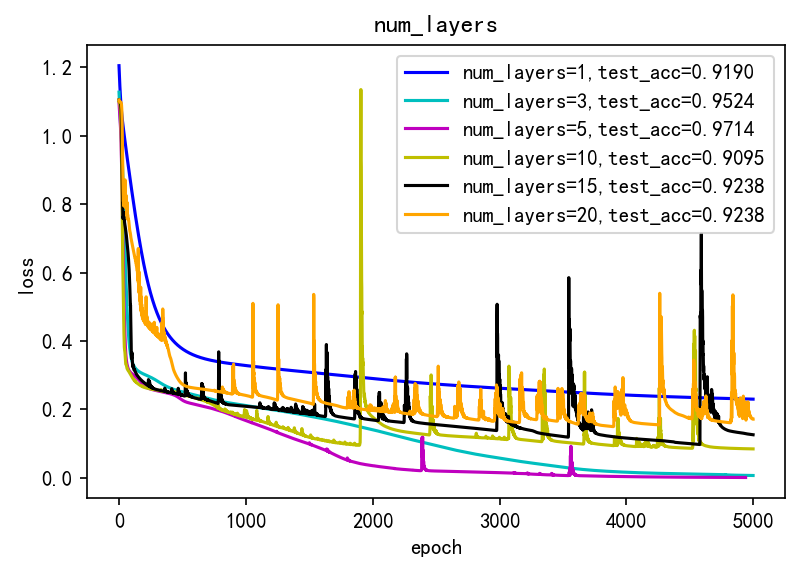

In [145]:
hidden_size = 32
num_layers = [1,3,5,10,15,20]
activation = 'tanh'
learning_rate = 0.001
color=['b', 'c', 'm', 'y', 'k', 'orange']
plt.figure(dpi=150)

for i,nl in enumerate(num_layers):
    print('num_layers:{}'.format(nl))
    model = FeedForwardNet(input_size=2, hidden_size=hidden_size, output_size=3, num_layers=nl, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    losses = fit(model, optimizer, criterion, x, y, epochs=5000, tol=1e-3)
    # 计算测试集的准确率
    y_pred = predict(model, x_test)
    y_pred = y_pred.numpy()
    y_pred = np.argmax(y_pred, axis=1)
    acc = np.sum(y_pred==y_test)/len(y_test)
    print('test accuracy: {:.6f}'.format(acc))
    # 绘制损失函数的变化曲线
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('num_layers')
    plt.plot(losses,color=color[i],label='num_layers={},test_acc={:.4f}'.format(nl,acc))
plt.legend()
plt.show()

learning_rate: 0.0001


100%|██████████| 5000/5000 [00:11<00:00, 441.74it/s]


epoch: 5000, train_loss: 0.195804
test accuracy: 0.919048
learning_rate: 0.001


 99%|█████████▉| 4940/5000 [00:16<00:00, 308.03it/s]


epoch: 4941, train_loss: 0.000999
test accuracy: 0.971429
learning_rate: 0.01


100%|██████████| 5000/5000 [00:13<00:00, 375.94it/s]


epoch: 5000, train_loss: 0.075992
test accuracy: 0.947619
learning_rate: 0.1


100%|██████████| 5000/5000 [00:14<00:00, 348.60it/s]


epoch: 5000, train_loss: 1.100258
test accuracy: 0.333333
learning_rate: 0.5


100%|██████████| 5000/5000 [00:15<00:00, 318.48it/s]


epoch: 5000, train_loss: 1.201511
test accuracy: 0.333333


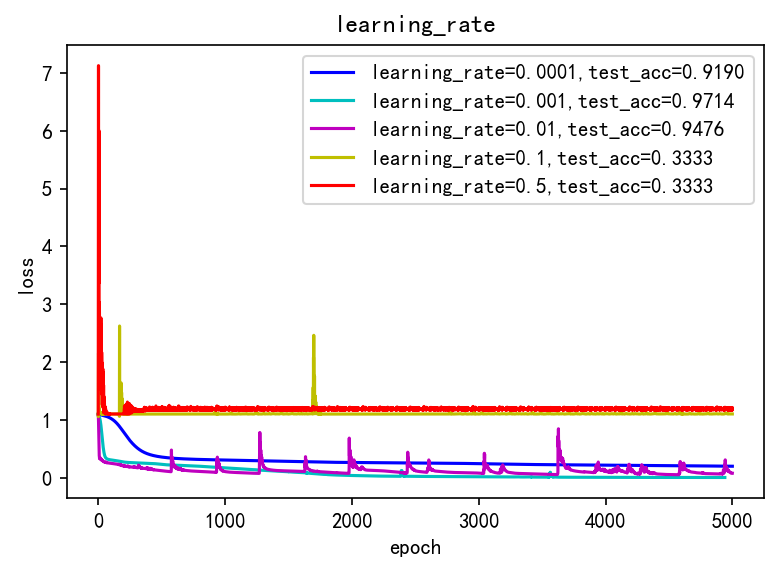

In [152]:
hidden_size = 32
num_layers = 5
activation = 'tanh'
learning_rate = [1e-4,0.001,0.01,0.1,0.5]
color=['b', 'c', 'm', 'y', 'r']
plt.figure(dpi=150)

for i,lr in enumerate(learning_rate):
    print('learning_rate: {}'.format(lr))
    model = FeedForwardNet(input_size=2, hidden_size=hidden_size, output_size=3, num_layers=num_layers, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = fit(model, optimizer, criterion, x, y, epochs=5000, tol=1e-3)
    # 计算测试集的准确率
    y_pred = predict(model, x_test)
    y_pred = y_pred.numpy()
    y_pred = np.argmax(y_pred, axis=1)
    acc = np.sum(y_pred==y_test)/len(y_test)
    print('test accuracy: {:.6f}'.format(acc))
    # 绘制损失函数的变化曲线
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('learning_rate')
    plt.plot(losses,color=color[i],label='learning_rate={},test_acc={:.4f}'.format(lr,acc))
plt.legend()
plt.show()